# Idealista 

Lucho Ago| 2024

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import joblib






### Import Datasets

In [2]:
df_idealista1 = pd.read_csv("idealista18_1.csv", delimiter=';', encoding='utf-8')
df_idealista1_raw = df_idealista1.copy()
df_idealista2 = pd.read_csv("idealista18_2.csv", delimiter=';', encoding='utf-8')
df_idealista2_raw = df_idealista2.copy()
df_idealista = pd.concat([df_idealista1,df_idealista2] ,ignore_index=True)
df_idealista_raw = df_idealista.copy()
# Intentar guardar el DataFrame en formato Parquet
try:
    df_idealista.to_parquet("idealista.parquet")
    print("Archivo guardado exitosamente como Parquet.")
except Exception as e:
    print(f"Error al guardar el archivo como Parquet: {e}")
df_idealista.head()

C:\Users\Lupin III\AppData\Local\Temp\ipykernel_20560\3225051408.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_idealista1 = pd.read_csv("idealista18_1.csv", delimiter=';', encoding='utf-8')


Error al guardar el archivo como Parquet: ("Expected bytes, got a 'float' object", 'Conversion failed for column LONGITUDE with type object')


,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
0,A12377633511549727658,201812,109000,173.015.873.015.873,HOME,SALE,63,3,1,1,...,0,1,41.666.111.934.628,0.313528969922085,281.442.478.398.048,-372.678.548.425.368,403.835.100.173.352,Madrid,HOME,SALE
1,A7691539882862170545,201809,155000,238.461.538.461.539,HOME,SALE,65,2,1,0,...,0,1,447.723.688.393.159,0.109564842335112,293.405.190.097.516,-372.676.357.266.584,403.803.749.921.673,Madrid,HOME,SALE
2,A4316988685482817826,201809,158000,202.564.102.564.103,HOME,SALE,78,3,1,1,...,0,1,429.495.374.817.407,0.217547154878065,278.889.378.790.152,-372.568.322.685.349,403.817.962.040.154,Madrid,HOME,SALE
3,A12032801997263349694,201812,126000,1680,HOME,SALE,75,3,1,1,...,0,1,486.193.949.824.652,0.355737992157404,345.559.011.393.018,-373.257.808.114.098,403.788.157.669.587,Madrid,HOME,SALE
4,A16032891972289007994,201803,184000,1840,HOME,SALE,100,3,2,1,...,0,1,478.646.309.729.676,0.395205981756094,339.942.430.854.762,-373.219.598.875.872,403.794.308.050.838,Madrid,HOME,SALE


### Pre-Analisis

In [3]:
df_idealista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194923 entries, 0 to 194922
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ASSETID                        194923 non-null  object 
 1   PERIOD                         194923 non-null  int64  
 2   PRICE                          194923 non-null  int64  
 3   UNITPRICE                      194923 non-null  object 
 4   ADTYPOLOGYID                   194923 non-null  object 
 5   ADOPERATIONID                  194923 non-null  object 
 6   CONSTRUCTEDAREA                194923 non-null  int64  
 7   ROOMNUMBER                     194923 non-null  int64  
 8   BATHNUMBER                     194923 non-null  int64  
 9   HASTERRACE                     194923 non-null  int64  
 10  HASLIFT                        194923 non-null  int64  
 11  HASAIRCONDITIONING             194923 non-null  int64  
 12  AMENITYID                     

In [4]:
df_idealista.describe()

,PERIOD,PRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,...,CONSTRUCTIONYEAR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3
count,194923.000000,1.949230e+05,194923.000000,194923.000000,194923.000000,194923.000000,194923.000000,194923.000000,194923.000000,194923.000000,...,100011.000000,184849.000000,174921.000000,194923.000000,194923.000000,194923.000000,194922.000000,194923.000000,194923.000000,194923.000000
mean,201808.376692,3.589703e+05,100.513085,2.750722,1.561191,0.330531,0.724578,0.458735,2.878644,0.170072,...,1961.112568,2.922737,1.107723,1962.392011,6.634871,35.570600,4.771519,0.025425,0.171150,0.803425
std,3.710309,3.499918e+05,59.470246,1.194734,0.768198,0.470405,0.446728,0.498296,0.408244,0.375697,...,54.299618,2.291997,0.310031,32.053919,2.823312,49.447031,1.478445,0.157414,0.376641,0.397409
min,201803.000000,2.000000e+04,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,-1.000000,1.000000,1588.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,201803.000000,1.590000e+05,66.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,1951.000000,1.000000,1.000000,1951.000000,5.000000,11.000000,4.000000,0.000000,0.000000,1.000000
50%,201809.000000,2.590000e+05,86.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,...,1967.000000,2.000000,1.000000,1966.000000,6.000000,20.000000,5.000000,0.000000,0.000000,1.000000
75%,201812.000000,4.260000e+05,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,...,1980.000000,4.000000,1.000000,1980.000000,8.000000,36.000000,6.000000,0.000000,0.000000,1.000000
max,201812.000000,8.133000e+06,985.000000,93.000000,20.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,2291.000000,11.000000,2.000000,2018.000000,34.000000,1499.000000,9.000000,1.000000,1.000000,1.000000


In [5]:
df_idealista.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION'],
      dtype='object')

In [6]:
vars1 = ["CONSTRUCTEDAREA","ROOMNUMBER","BATHNUMBER", "ISSTUDIO","CONSTRUCTIONYEAR" ] + ["PRICE"]

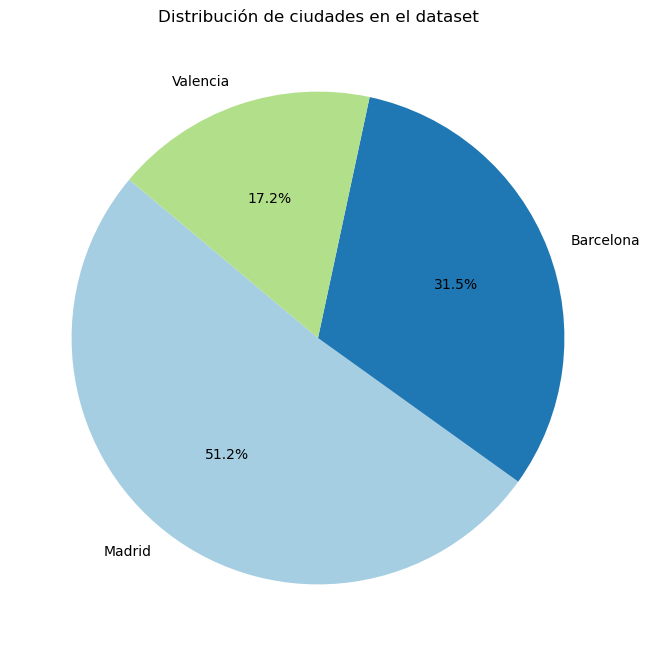

In [7]:
ciudades_frecuencia = df_idealista['CITYNAME'].value_counts()

# Crear gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(ciudades_frecuencia, labels=ciudades_frecuencia.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Agregar título
plt.title('Distribución de ciudades en el dataset')

# Mostrar gráfico
plt.show()

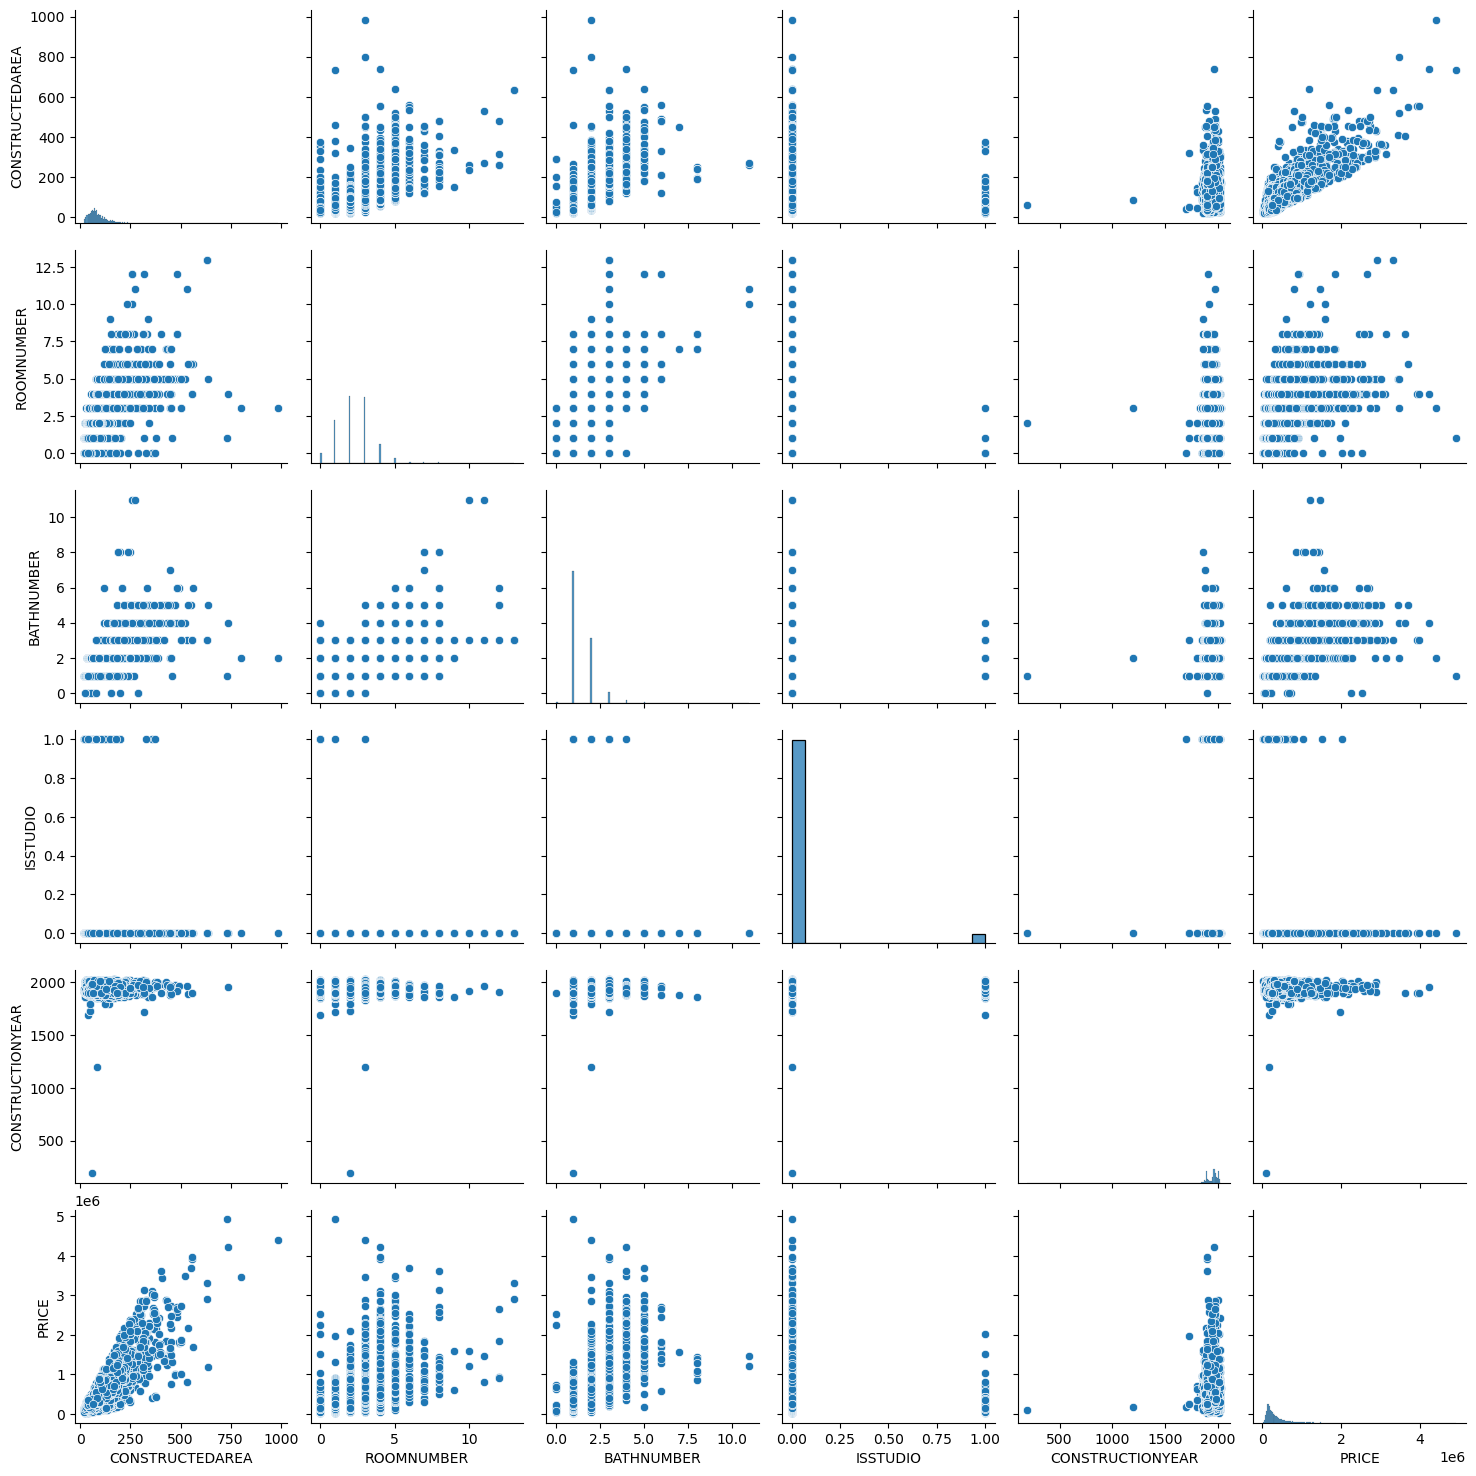

In [8]:
pair_plot = sns.pairplot(df_idealista[vars1].iloc[0:10000])
plt.show()

### Sepacion de Ciudades

In [9]:
barcelona = df_idealista[df_idealista["CITYNAME"]== "Barcelona"]
bacelona_raw = barcelona.copy()
madrid = df_idealista[df_idealista["CITYNAME"]== "Madrid"]
madrid_raw = madrid.copy()
valencia = df_idealista[df_idealista["CITYNAME"]== "Valencia"]
valencia_raw = valencia.copy()

In [10]:
len(barcelona)

61486

In [11]:
barca = barcelona.iloc[0:30000]
real = madrid.iloc[0:30000]

#### Analisis de Variables

In [12]:
barca.isna().sum()

ASSETID                              0
PERIOD                               0
PRICE                                0
UNITPRICE                            0
ADTYPOLOGYID                         0
ADOPERATIONID                        0
CONSTRUCTEDAREA                      0
ROOMNUMBER                           0
BATHNUMBER                           0
HASTERRACE                           0
HASLIFT                              0
HASAIRCONDITIONING                   0
AMENITYID                            0
HASPARKINGSPACE                      0
ISPARKINGSPACEINCLUDEDINPRICE        0
PARKINGSPACEPRICE                    0
HASNORTHORIENTATION                  0
HASSOUTHORIENTATION                  0
HASEASTORIENTATION                   0
HASWESTORIENTATION                   0
HASBOXROOM                           0
HASWARDROBE                          0
HASSWIMMINGPOOL                      0
HASDOORMAN                           0
HASGARDEN                            0
ISDUPLEX                 

In [13]:
madrid.isna().sum()

ASSETID                              0
PERIOD                               0
PRICE                                0
UNITPRICE                            0
ADTYPOLOGYID                         0
ADOPERATIONID                        0
CONSTRUCTEDAREA                      0
ROOMNUMBER                           0
BATHNUMBER                           0
HASTERRACE                           0
HASLIFT                              0
HASAIRCONDITIONING                   0
AMENITYID                            0
HASPARKINGSPACE                      0
ISPARKINGSPACEINCLUDEDINPRICE        0
PARKINGSPACEPRICE                    0
HASNORTHORIENTATION                  0
HASSOUTHORIENTATION                  0
HASEASTORIENTATION                   0
HASWESTORIENTATION                   0
HASBOXROOM                           0
HASWARDROBE                          0
HASSWIMMINGPOOL                      0
HASDOORMAN                           0
HASGARDEN                            0
ISDUPLEX                 

In [14]:
madrid.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION'],
      dtype='object')

In [15]:
madrid = madrid.drop(['CADCONSTRUCTIONYEAR','FLOORCLEAN','FLATLOCATIONID','CADCONSTRUCTIONYEAR',
                       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT','CADASTRALQUALITYID',], axis = 1)

<Axes: xlabel='PRICE', ylabel='Count'>

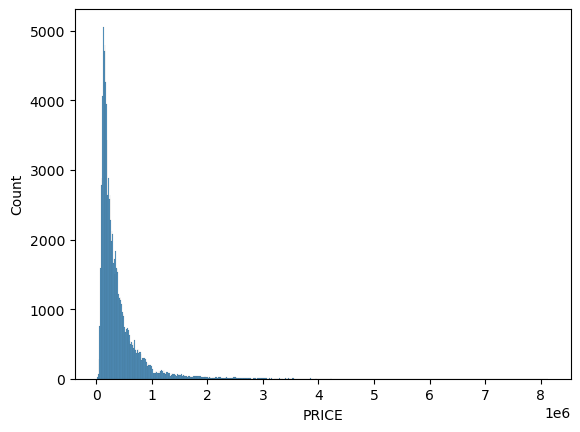

In [16]:
sns.histplot(data=madrid.PRICE)

In [17]:
madrid[madrid["PRICE"] >=3000000].head(5)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
424,A6264609981098515320,201812,3452000,841.951.219.512.195,HOME,SALE,410,5,5,0,...,1,0,170.211.859.876.271,0.159710072695498,0.543012341965098,-368.505.901.763.866,404.221.073.412.666,Madrid,HOME,SALE
661,A11550393092251054217,201812,4221000,571.177.266.576.455,HOME,SALE,739,4,4,1,...,0,1,208.820.875.324.197,0.219778009792484,0.298194710335674,-369.213.854.432.717,404.331.192.542.619,Madrid,HOME,SALE
712,A14685161454425479333,201812,3700000,672.727.272.727.273,HOME,SALE,550,6,5,1,...,0,1,216.270.888.529.665,0.573379320367158,274.656.833.431.414,-372.262.575.136.169,404.296.984.697.111,Madrid,HOME,SALE
3795,A3694300518337702967,201803,3122000,867.222.222.222.222,HOME,SALE,360,4,3,1,...,0,1,0.786398490245473,0.347409607310251,161.250.922.735.902,-371.306.836.505.077,404.166.496.765.346,Madrid,HOME,SALE
5512,A3694300518337702967,201803,3048000,846.666.666.666.667,HOME,SALE,360,4,3,1,...,0,1,0.914121327997867,0.387038553108979,171.474.787.390.184,-371.337.855.388.978,404.203.504.771.346,Madrid,HOME,SALE


In [18]:
madrid[madrid["PRICE"] >=1000000]

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
282,A8722408526364410780,201812,1872000,3744,HOME,SALE,500,5,4,0,...,0,1,0.372818546935124,0.227928696082233,0.724298503543857,-370.237.936.623.444,404.134.177.966.042,Madrid,HOME,SALE
284,A12148188622595805413,201812,1593000,474.107.142.857.143,HOME,SALE,336,9,2,0,...,1,0,0.662928552416907,0.20352540270561,0.218222473466596,-369.608.139.428.053,404.176.000.465.923,Madrid,HOME,SALE
293,A12854544717629678654,201812,1169000,687.647.058.823.529,HOME,SALE,170,3,2,0,...,0,1,132.530.869.204.656,0.254444649676176,0.77926138155858,-369.926.537.318.481,404.279.862.681.376,Madrid,HOME,SALE
314,A2113152695864515186,201812,1624000,709.170.305.676.856,HOME,SALE,229,2,3,0,...,0,1,0.495013844636938,0.146165216901099,0.866367724930902,-370.295.320.930.031,404.209.909.134.659,Madrid,HOME,SALE
341,A1191486817890724333,201812,1114000,655.294.117.647.059,HOME,SALE,170,2,3,0,...,0,1,0.350557661026617,0.274587195640003,10.638.099.209.029,-370.663.170.858.581,404.143.017.991.798,Madrid,HOME,SALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193644,A9004006686905677355,201806,1497000,525.263.157.894.737,HOME,SALE,285,7,4,1,...,0,1,0.687636409041469,0.282803636991033,151.114.088.086.517,-371.189.859.081.612,404.163.776.050.022,Madrid,HOME,SALE
193671,A10112386086012366430,201806,1005000,564.606.741.573.034,HOME,SALE,178,5,2,0,...,0,1,0.712154555384827,0.2521761009111,148.671.627.912.731,-371.063.156.184.489,404.203.043.311.676,Madrid,HOME,SALE
193692,A17175755836741930714,201812,1073000,7400,HOME,SALE,145,2,2,0,...,0,1,0.783790518422869,0.320096092551905,149.492.918.086.386,-371.147.055.476.861,404.126.685.138.812,Madrid,HOME,SALE
193717,A2155029286989513743,201803,1006000,617.177.914.110.429,HOME,SALE,163,3,3,0,...,0,1,0.612448406567403,0.316113863342276,141.885.844.345.054,-371.086.352.732.411,404.154.650.514.487,Madrid,HOME,SALE


In [19]:
madrid = madrid[madrid["PRICE"]<1000000]
madrid

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
0,A12377633511549727658,201812,109000,173.015.873.015.873,HOME,SALE,63,3,1,1,...,0,1,41.666.111.934.628,0.313528969922085,281.442.478.398.048,-372.678.548.425.368,403.835.100.173.352,Madrid,HOME,SALE
1,A7691539882862170545,201809,155000,238.461.538.461.539,HOME,SALE,65,2,1,0,...,0,1,447.723.688.393.159,0.109564842335112,293.405.190.097.516,-372.676.357.266.584,403.803.749.921.673,Madrid,HOME,SALE
2,A4316988685482817826,201809,158000,202.564.102.564.103,HOME,SALE,78,3,1,1,...,0,1,429.495.374.817.407,0.217547154878065,278.889.378.790.152,-372.568.322.685.349,403.817.962.040.154,Madrid,HOME,SALE
3,A12032801997263349694,201812,126000,1680,HOME,SALE,75,3,1,1,...,0,1,486.193.949.824.652,0.355737992157404,345.559.011.393.018,-373.257.808.114.098,403.788.157.669.587,Madrid,HOME,SALE
4,A16032891972289007994,201803,184000,1840,HOME,SALE,100,3,2,1,...,0,1,478.646.309.729.676,0.395205981756094,339.942.430.854.762,-373.219.598.875.872,403.794.308.050.838,Madrid,HOME,SALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194918,A18002754432335399361,201809,129000,167.532.467.532.468,HOME,SALE,77,3,1,1,...,0,1,7.384.388.495.756,0.47508167306898,591.125.787.686.882,-361.884.888.329.904,404.313.906.573.229,Madrid,HOME,SALE
194919,A2102651372839229475,201809,99000,2062.5,HOME,SALE,48,2,1,0,...,0,1,744.360.321.007.083,0.632111273529584,592.114.094.183.519,-361.867.602.901.355,404.331.123.097.844,Madrid,HOME,SALE
194920,A2406252856277846885,201809,186000,1550,HOME,SALE,120,4,2,0,...,0,1,769.629.870.036.043,0.31008825739174,624.941.245.450.335,-361.489.342.334.057,404.307.360.846.672,Madrid,HOME,SALE
194921,A826391189699187644,201812,102000,156.923.076.923.077,HOME,SALE,65,3,1,0,...,1,0,747.717.363.492.426,0.52772425766795,597.912.047.174.709,-361.800.848.969.785,404.323.140.753.933,Madrid,HOME,SALE


<Axes: xlabel='PRICE', ylabel='Count'>

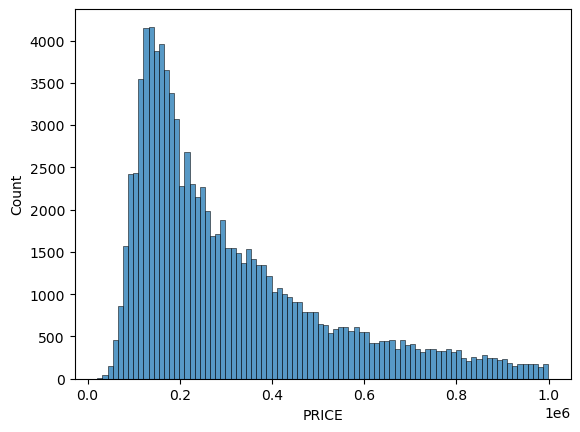

In [20]:
sns.histplot(data=madrid.PRICE)

##### Seleccion Columnas

In [21]:
for columna in madrid.columns:
    print(madrid[columna].value_counts())

ASSETID
A5463639993615125363     11
A2282202115281541721      9
A14882068007191593522     9
A1315840462730187222      9
A9858360437524013306      8
                         ..
A11593829242021880670     1
A288636352287297962       1
A4418221822317737269      1
A649196676625623665       1
A1572713692907348294      1
Name: count, Length: 71392, dtype: int64
PERIOD
201812    43496
201803    20635
201809    17361
201806    12497
Name: count, dtype: int64
PRICE
137000    485
127000    465
128000    443
132000    429
130000    423
         ... 
25000       1
21000       1
34000       1
32000       1
38000       1
Name: count, Length: 974, dtype: int64
UNITPRICE
2000                   411
3000                   248
5000                   218
4000                   209
2200                   175
                      ... 
5110                     1
4181.25                  1
374.489.795.918.367      1
219.135.802.469.136      1
108.955.223.880.597      1
Name: count, Length: 26930, dtype: int64

In [22]:
madrid = madrid.drop_duplicates("ASSETID")

In [23]:
madrid = madrid.drop(["PERIOD","UNITPRICE", "ADTYPOLOGYID","ADOPERATIONID",
                     "LONGITUDE","LATITUDE","ISPARKINGSPACEINCLUDEDINPRICE",
                      'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION', "CONSTRUCTIONYEAR",
                      "DISTANCE_TO_CITY_CENTER", "DISTANCE_TO_METRO","DISTANCE_TO_STREET"], axis=1)

In [24]:
madrid.head()

,ASSETID,PRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,...,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3
0,A12377633511549727658,109000,63,3,1,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,1
1,A7691539882862170545,155000,65,2,1,0,1,1,3,0,...,0,0,0,0,0,0,0,0,0,1
2,A4316988685482817826,158000,78,3,1,1,1,1,3,0,...,1,0,0,0,0,0,0,0,0,1
3,A12032801997263349694,126000,75,3,1,1,1,1,3,0,...,1,0,0,1,0,0,0,0,0,1
4,A16032891972289007994,184000,100,3,2,1,1,1,3,0,...,1,0,1,0,0,0,0,0,0,1


##### Modelo

In [25]:
#madrid.drop("ASSETID", axis=1).corr()["PRICE"].abs().sort_values(ascending=False)


In [26]:
madrid.columns

Index(['ASSETID', 'PRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'PARKINGSPACEPRICE', 'HASNORTHORIENTATION',
       'HASSOUTHORIENTATION', 'HASEASTORIENTATION', 'HASWESTORIENTATION',
       'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL', 'HASDOORMAN',
       'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR', 'BUILTTYPEID_1',
       'BUILTTYPEID_2', 'BUILTTYPEID_3'],
      dtype='object')

In [27]:
variables_cor = ['CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'PARKINGSPACEPRICE', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL', 'HASDOORMAN',
       'HASGARDEN','BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',]

C:\Users\Lupin III\AppData\Local\Temp\ipykernel_20560\2579800449.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cMap = plt.cm.get_cmap("bwr", lut=n_colors)


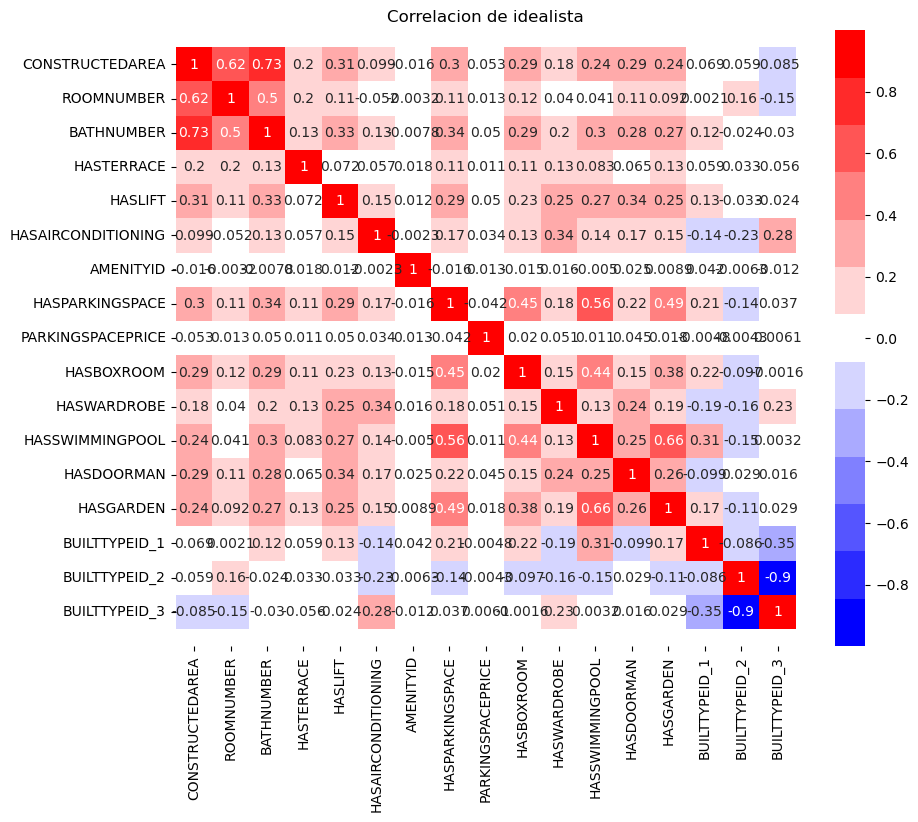

In [28]:
n_colors = 13
cMap = plt.cm.get_cmap("bwr", lut=n_colors)

#Heatmap
fig = plt.figure( figsize=(10,8))
plt.title("Correlacion de idealista")

h_map = sns.heatmap(madrid[variables_cor].corr().values,
                    vmin= -1., vmax=1,
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(madrid[variables_cor].columns),
                    yticklabels=list(madrid[variables_cor].columns))

plt.xticks(rotation=90)

#Poner ticks de la barra de color

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range (-8,9,2)]
cbar.set_ticks(l_ticks)

#Arreglar cosillas

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top -0.5)

plt.show()

In [29]:
madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71392 entries, 0 to 189922
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ASSETID              71392 non-null  object
 1   PRICE                71392 non-null  int64 
 2   CONSTRUCTEDAREA      71392 non-null  int64 
 3   ROOMNUMBER           71392 non-null  int64 
 4   BATHNUMBER           71392 non-null  int64 
 5   HASTERRACE           71392 non-null  int64 
 6   HASLIFT              71392 non-null  int64 
 7   HASAIRCONDITIONING   71392 non-null  int64 
 8   AMENITYID            71392 non-null  int64 
 9   HASPARKINGSPACE      71392 non-null  int64 
 10  PARKINGSPACEPRICE    71392 non-null  int64 
 11  HASNORTHORIENTATION  71392 non-null  int64 
 12  HASSOUTHORIENTATION  71392 non-null  int64 
 13  HASEASTORIENTATION   71392 non-null  int64 
 14  HASWESTORIENTATION   71392 non-null  int64 
 15  HASBOXROOM           71392 non-null  int64 
 16  HASWARDR

#### Modelado

madrid.info()

In [30]:
X = madrid.drop(["PRICE","ASSETID"], axis = 1)
y = madrid["PRICE"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 21)
X_train

,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,PARKINGSPACEPRICE,HASNORTHORIENTATION,...,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3
18399,144,4,2,1,1,1,3,1,1,1,...,1,0,0,1,0,0,0,0,1,0
179947,51,1,1,0,0,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,1
13058,135,3,2,0,1,0,3,1,1,0,...,0,1,0,1,0,0,0,1,0,0
60473,55,0,1,0,1,0,3,1,1,0,...,0,1,0,0,0,1,0,0,0,1
33979,59,2,1,1,1,1,3,0,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56219,120,4,2,0,1,0,3,1,1,0,...,1,0,0,0,0,0,0,0,0,1
51268,50,2,2,0,1,1,3,0,1,0,...,0,0,1,0,0,0,0,0,0,1
177917,86,2,2,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9702,70,2,1,0,1,1,3,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [31]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit (X_train, y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [32]:
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)


print("Random Forest MSE: ", np.sqrt(rf_mse))
print("Linear Regression MSE: ", np.sqrt(lr_mse))

print("\n Sample predictions: ")
num_samples = 10

for i in range(num_samples):
    print(f" - Random Forest: Predited: {rf_predictions[i]}, Actual: {y_test.iloc[i]}")
    print(f" - Linear Regresion: Predited: {lr_predictions[i]}, Actual: {y_test.iloc[i]}")
    print()

Random Forest MSE:  106589.36595253008
Linear Regression MSE:  123120.32743184581

 Sample predictions: 
 - Random Forest: Predited: 237755.0, Actual: 294000
 - Linear Regresion: Predited: 275576.9939857981, Actual: 294000

 - Random Forest: Predited: 357654.321067821, Actual: 309000
 - Linear Regresion: Predited: 327744.2640176721, Actual: 309000

 - Random Forest: Predited: 411581.6666666666, Actual: 658000
 - Linear Regresion: Predited: 453213.2211061713, Actual: 658000

 - Random Forest: Predited: 146414.79770259841, Actual: 115000
 - Linear Regresion: Predited: 130074.56885983181, Actual: 115000

 - Random Forest: Predited: 241559.52380952382, Actual: 164000
 - Linear Regresion: Predited: 214511.61876385397, Actual: 164000

 - Random Forest: Predited: 158399.61904761905, Actual: 127000
 - Linear Regresion: Predited: 157868.15977642758, Actual: 127000

 - Random Forest: Predited: 260176.66666666663, Actual: 303000
 - Linear Regresion: Predited: 199082.60124979616, Actual: 303000

 

##### DeepLearing

In [33]:
n_folds = 3
kf = KFold(n_folds, shuffle=False)

In [34]:
# Inicialización del MLPRegressor
mlp_r = MLPRegressor(solver="lbfgs",
                     activation="relu",
                     tol=1.e-4,
                     max_iter=100,
                     warm_start=False,
                     shuffle=False)

# Definir el espacio de búsqueda para los hiperparámetros
l_hidden_layer_sizes = [(20,),(20,20)]
l_alpha = [10.**k for k in range (-2, 0)]

grid = {"alpha": l_alpha, 
        "hidden_layer_sizes": l_hidden_layer_sizes, 
        "solver": ["lbfgs", "adam"],
        "learning_rate": ["invscaling", "adaptive"]}

In [35]:

mlp_r_cv = RandomizedSearchCV(mlp_r, grid, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=1)

# Ajustar el modelo
mlp_r_cv.fit(X_train, y_train)

# Imprimir los resultados
print("Tuned hyperparameters: (best parameters)", mlp_r_cv.best_params_)
print("Negative root mean squared error: ", mlp_r_cv.best_score_)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

Tuned hyperparameters: (best parameters) {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (20, 20), 'alpha': 0.1}
Negative root mean squared error:  -133290.74916178078


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
preds = mlp_r_cv.predict(X_test)

In [37]:
mlp_mse = mean_squared_error(y_test, preds)

print ("MLP MSE", np.sqrt(mlp_mse))

MLP MSE 133586.6362874628


In [ ]:
# Guardar el modelo entrenado
joblib.dump(mlp_r_cv.best_estimator_, 'modelo_mlp_r_cv.pkl')

##### Explicando el modelo

In [38]:
coefficients = lr_model.coef_

intercept = lr_model.intercept_

feature_names = X_train.columns

coeff_df = pd.DataFrame({"Feature": feature_names,"Coefficient": coefficients})

print(f"Intercept: {intercept}")
print(coeff_df)

Intercept: -53384.988418639405
                Feature   Coefficient
0       CONSTRUCTEDAREA   2962.315722
1            ROOMNUMBER -20046.598592
2            BATHNUMBER  65655.846859
3            HASTERRACE -37033.033329
4               HASLIFT  68994.028101
5    HASAIRCONDITIONING  27502.014607
6             AMENITYID   2503.854487
7       HASPARKINGSPACE -15840.227986
8     PARKINGSPACEPRICE      0.815003
9   HASNORTHORIENTATION   5192.503314
10  HASSOUTHORIENTATION   6191.801605
11   HASEASTORIENTATION    108.569248
12   HASWESTORIENTATION  11058.827379
13           HASBOXROOM -15312.464825
14          HASWARDROBE  10119.025959
15      HASSWIMMINGPOOL  14354.136515
16           HASDOORMAN  59729.548143
17            HASGARDEN -49315.319433
18             ISDUPLEX -37673.530696
19             ISSTUDIO -31612.459331
20         ISINTOPFLOOR  22888.466803
21        BUILTTYPEID_1  11223.882257
22        BUILTTYPEID_2  -1454.637163
23        BUILTTYPEID_3  -9769.245093


In [39]:
importances = rf_model.feature_importances_

feature_names = X_train.columns

importance_df = pd.DataFrame({"Feature": feature_names,"Importance": importances})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)

                Feature  Importance
0       CONSTRUCTEDAREA    0.677651
4               HASLIFT    0.063855
1            ROOMNUMBER    0.036740
2            BATHNUMBER    0.022004
16           HASDOORMAN    0.017954
3            HASTERRACE    0.016878
5    HASAIRCONDITIONING    0.015344
10  HASSOUTHORIENTATION    0.014129
13           HASBOXROOM    0.014068
14          HASWARDROBE    0.013570
11   HASEASTORIENTATION    0.013456
7       HASPARKINGSPACE    0.013001
17            HASGARDEN    0.012366
12   HASWESTORIENTATION    0.011592
9   HASNORTHORIENTATION    0.009302
15      HASSWIMMINGPOOL    0.008314
6             AMENITYID    0.008056
22        BUILTTYPEID_2    0.006401
23        BUILTTYPEID_3    0.006358
18             ISDUPLEX    0.005887
8     PARKINGSPACEPRICE    0.005458
20         ISINTOPFLOOR    0.003731
21        BUILTTYPEID_1    0.002731
19             ISSTUDIO    0.001154


##### Conclusion

Se puede ver en algunos lugares donde el area, es mucho mas importante la ubicacion en base al precio. Y la distancia puede jugar mucho a favor, con la diferencia del otro algortimo.